## Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, copy
from pathlib import Path
from pprint import pprint

In [2]:
%load_ext autoreload
%autoreload 2

THIS_PATH = Path(os.path.abspath(''))

import matplotlib as mpl
plt.rcParams['figure.figsize'] = [5, 2.5]
plt.rcParams['figure.autolayout'] = True
mpl.rcParams.update({'axes.grid': True})

## Test signal

### UCA IRs

Ground truth distances (m): [1.25730937 1.9336625 ]
TDOAS:
array([[ 0.        ,  0.        ],
       [-5.12222139,  0.        ],
       [13.9941691 , 19.79074373],
       [19.11639049, 19.79074373]])


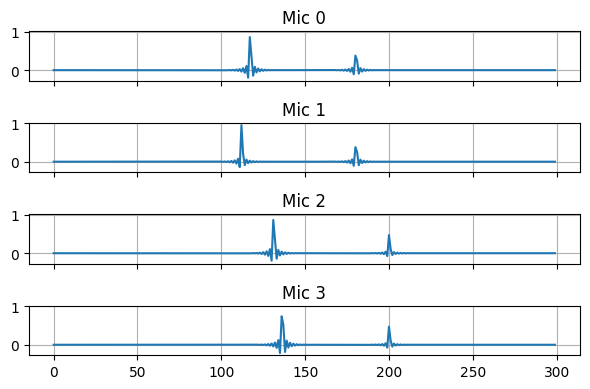

In [3]:
from em.emmc import EMMC_Setup, EMMC_Estimate, compute_tdoas
from em.sim_utils import gen_ir_uca

mic_array_radius_metres = 0.3
fs = 16e3
setup = EMMC_Setup(
    num_ref=2,
    num_mics=4,
    mic_array_radius=mic_array_radius_metres*fs/343,
    toa_range=(100, 300),
    return_history=True,
)

irlen = 300
toas_gt = np.array((117.3, 180.4))
doas_gt = np.array((np.pi/3, np.pi/4))
gains_gt = np.array((1, 0.5))

irs_gt = gen_ir_uca(irlen, toas_gt, doas_gt, gains_gt, setup)
est_gt = EMMC_Estimate(gains_gt, toas_gt, doas_gt, setup)

dists_gt = toas_gt * 343 / fs / 2
print(f'Ground truth distances (m): {dists_gt}')
print('TDOAS:')
pprint(compute_tdoas(doas_gt, setup))

from em.plot_utils import plot_signals_mc
plot_signals_mc(irs_gt, 'multi', alpha=0.8, multifigsize=(6, 4))
# plot_signals_mc(irs_gt, 'multi', [80, 240], alpha=0.8, multifigsize=(6, 4))

### Source chirp signal

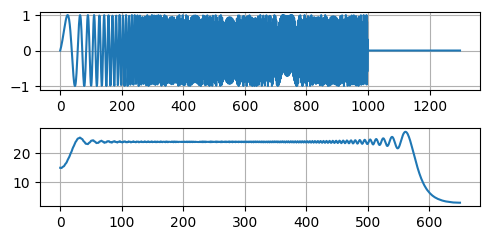

In [4]:
from em.sim_utils import gen_chirp
from numpy.fft import fft, rfft, ifft, irfft, fftfreq, rfftfreq

f0 = 0.5 / 100  # unit is periods per sample. 
                # 0.5 is Nyquist frequency
f1 = 0.45
chp_len = 1000
N = chp_len + irs_gt.shape[1]
src_signal = gen_chirp(f0, f1, chp_len, N)
src_signal_fft = rfft(src_signal)
fig, axs = plt.subplots(2, 1)
axs[0].plot(src_signal)
axs[1].plot(np.abs(src_signal_fft))
plt.show()

### Mic signals

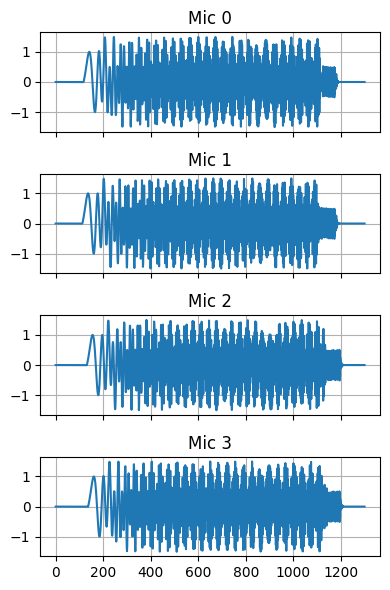

In [5]:
%matplotlib inline
mic_signals = np.array([
    np.convolve(src_signal, ir, mode='full')[:N] \
    for ir in irs_gt
])
# plot_signals_mc(mic_signals, 'multi', (1000, None))
plot_signals_mc(mic_signals, 'multi')

## EM

In [6]:
from em.emmc import EMMC
init_est = EMMC_Estimate(
    gains=np.random.uniform(0, 1, setup.num_ref),
    toas=np.random.uniform(*setup.toa_range, setup.num_ref),
    phis=np.random.uniform(*setup.phi_range[:2], setup.num_ref),
    setup=setup,
)
np.set_printoptions(precision=2)
# init_est = est_gt
init_est

Gains: [0.74 0.72]
TOAs: [210.23 130.65]
DOAs: [-0.45 -2.7 ]
TDOAs:
[[  0.     0.  ]
 [ 18.72  -6.59]
 [ 25.15 -25.25]
 [  6.43 -18.66]]

In [7]:
est_gt

Gains: [1.  0.5]
TOAs: [117.3 180.4]
DOAs: [1.05 0.79]
TDOAs:
[[ 0.    0.  ]
 [-5.12  0.  ]
 [13.99 19.79]
 [19.12 19.79]]

In [12]:
setup.max_iter = 10
setup.Mstep_maximizer = 'nelder-mead'

In [9]:
# %load_ext snakeviz

In [10]:
from funcy import nth, take

In [16]:
emmc_gen = EMMC(src_signal, mic_signals, setup, init_est)
hist = [init_est] + take(10, emmc_gen)
hist[-1]

Took 28 iterations to minimize
Took 28 iterations to minimize
Took 28 iterations to minimize
Took 28 iterations to minimize
Took 28 iterations to minimize
Took 26 iterations to minimize
Took 28 iterations to minimize
Took 27 iterations to minimize
Took 27 iterations to minimize
Took 27 iterations to minimize
Took 27 iterations to minimize
Took 27 iterations to minimize
Took 27 iterations to minimize
Took 26 iterations to minimize
Took 28 iterations to minimize
Took 27 iterations to minimize
Took 28 iterations to minimize
Took 28 iterations to minimize
Took 27 iterations to minimize
Took 25 iterations to minimize


Gains: [0.5 0.5]
TOAs: [117.29 117.3 ]
DOAs: [1.05 1.05]
TDOAs:
[[ 0.    0.  ]
 [-5.11 -5.12]
 [14.01 14.  ]
 [19.12 19.12]]

In [17]:
%matplotlib qt
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))
labels = [f'ref {r}' for r in range(setup.num_ref)]
axs[0].plot([est.gains for est in hist], label=labels)
axs[0].hlines(gains_gt, 0, len(hist), colors='r', linestyles='dashed')
axs[0].set_title('Gains')
axs[0].legend()
axs[1].plot([est.toas for est in hist], label=labels)
axs[1].hlines(toas_gt, 0, len(hist), colors='r', linestyles='dashed')
axs[1].set_title('TOAs')
axs[2].plot([est.phis for est in hist], label=labels)
axs[2].hlines(doas_gt, 0, len(hist), colors='r', linestyles='dashed')
axs[2].set_title('DOAs')
plt.show()